In [1]:
# !pip install lightning
# !pip install matplotlib
# !pip install torch 
# !pip install tqdm
# !pip install 'numpy<2'
# !pip install -U 'tensorboard'
# !pip install -U 'tensorboardX'
# !pip install pandas
# !pip install scikit-learn
# !pip install torchvision
# !pip install gmsh
# !pip install cvxpy
# !pip install prettytable
# !pip install torchviz


# !python3 -m venv carp_env
# !carp_env/bin/python3 -m pip install ipykernel
# !carp_env/bin/python -m ipykernel install --user --name=carp_env
# !carp_env/bin/python -m pip install -r requirements.txt


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from lightning.pytorch import Trainer, seed_everything, callbacks
from lightning.pytorch.loggers import TensorBoardLogger

from models.sdf_models import LitSdfAE
from models.sdf_models import AE
from models.sdf_models import AE_DeepSDF, AE_DeepSDF_explicit_radius
from datasets.SDF_dataset import SdfDataset, SdfDatasetSurface, collate_fn_surface

# Add the parent directory of NN_TopOpt to the system path
sys.path.append(os.path.abspath('NN_TopOpt'))

root_path = 'shape_datasets'

dataset_files = [f'{root_path}/ellipse_sdf_dataset_smf22_arc_ratio_5000.csv',
                 f'{root_path}/triangle_sdf_dataset_smf20_arc_ratio_5000.csv', 
                 f'{root_path}/quadrangle_sdf_dataset_smf20_arc_ratio_5000.csv']

# dataset_files = ['shape_datasets/ellipse_sdf_dataset_smf22_arc_ratio_add.csv',
#                  'shape_datasets/triangle_sdf_dataset_smf20_arc_ratio_add.csv', 
#                  'shape_datasets/quadrangle_sdf_dataset_smf20_arc_ratio_add.csv']

dataset = SdfDataset(dataset_files, exclude_ellipse=False)

# Split dataset into train and test sets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing

# Use random_split to create train and test datasets
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, 
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)  # Set seed for reproducibility
)

# Create DataLoaders with shuffling
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # Enable shuffling for training data
    num_workers=15
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle test data
    num_workers=15
)

print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")


surface_files = [f'{root_path}/ellipse_sdf_surface_dataset_smf22_150.csv',
                 f'{root_path}/triangle_sdf_surface_dataset_smf20_150.csv',
                 f'{root_path}/quadrangle_sdf_surface_dataset_smf20_150.csv']

surface_dataset = SdfDatasetSurface(surface_files, cut_value=False)

surface_test_loader = torch.utils.data.DataLoader(
    surface_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=15,
    collate_fn=collate_fn_surface
)

print(f"len(surface_train_loader): {len(surface_test_loader)}")

Training set size: 12000000
Test set size: 3000000
len(surface_train_loader): 15


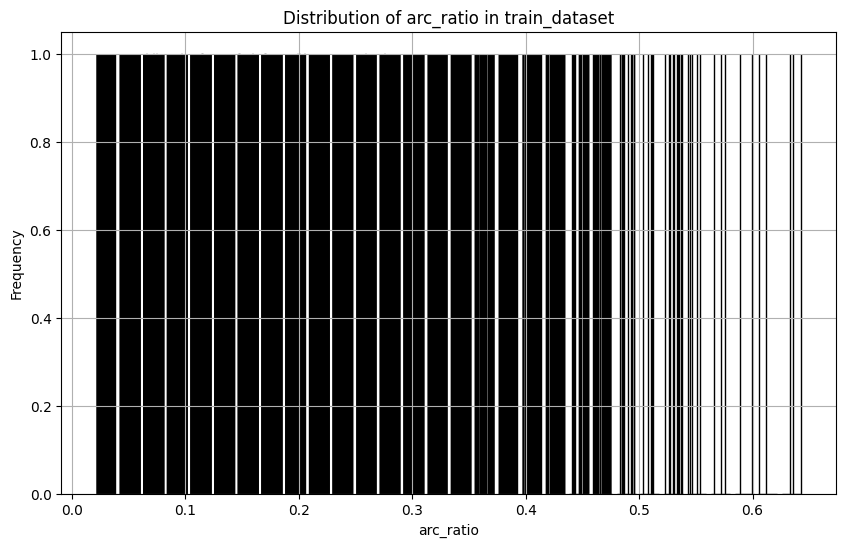

In [3]:
# Extract arc_ratio values from the train_dataset
# arc_ratios = [train_dataset[i][2] for i in range(5000)]

# # Plot the distribution of arc_ratio
# plt.figure(figsize=(10, 6))
# plt.hist(arc_ratios, bins=30, edgecolor='black')
# plt.title('Distribution of arc_ratio in train_dataset')
# plt.xlabel('arc_ratio')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()


In [2]:
run_name = 'uba_AE_deepSDF_explicit_radius_orthogonality'

In [3]:
MAX_EPOCHS = 3
MAX_STEPS = MAX_EPOCHS * len(train_loader)

# Training setup
trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator='auto',
    devices=1,
    logger=TensorBoardLogger(
        name='VAEi', 
        save_dir='./logs', 
        default_hp_metric=False, 
        version=run_name
    ),
    callbacks=[
        callbacks.ModelCheckpoint(
            monitor='val_total_loss/dataloader_idx_0',
            mode='min',
            save_top_k=1,
            filename='best-model-{epoch:02d}-{val_total_loss:.2f}'
        ),
        callbacks.EarlyStopping(
            monitor='val_total_loss/dataloader_idx_0',
            patience=10,
            mode='min'
        )
    ],
    check_val_every_n_epoch=None,  # Disable validation every epoch
    val_check_interval=50000  # Perform validation every 2000 training steps
)

# Initialize model with L1 regularization
# vae_model = AE_DeepSDF(
#     input_dim=dataset.feature_dim, 
#     latent_dim=9, 
#     hidden_dim=128, 
#     regularization='l2',   # Use 'l1', 'l2', or None
#     reg_weight=1e-3        # Adjust the weight as needed
# )

vae_model = AE_DeepSDF_explicit_radius(
    input_dim=dataset.feature_dim, 
    latent_dim=9, 
    hidden_dim=128, 
    rad_latent_dim=2,
    rad_loss_weight=0.1,
    orthogonality_loss_weight=0.1,
    regularization='l2',   # Use 'l1', 'l2', or None
    reg_weight=1e-3        # Adjust the weight as needed
)

# vae_model = AE(
#         input_dim=dataset.feature_dim, 
#         latent_dim=3, 
#         hidden_dim=128, 
#         regularization='l2',   # Use 'l1', 'l2', or None
#         reg_weight=1e-3        # Adjust the weight as needed
#     )

# Initialize the trainer
vae_trainer = LitSdfAE(
    vae_model=vae_model, 
    learning_rate=1e-4, 
    reg_weight=1e-3, 
    regularization='l2',    # Should match the VAE model's regularization
    warmup_steps=1000, 
    max_steps=MAX_STEPS
)

# Train the model
trainer.fit(vae_trainer, train_loader, val_dataloaders=[test_loader, surface_test_loader])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/root/miniconda3/envs/virt_env/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'vae_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['vae_model'])`.
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                       | Params | Mode 
------------------------------------------------------------
0 | vae  | AE_DeepSDF_explicit_radius | 1.9 M  | train
------------------

Sanity Checking: |                                                                                            …

/root/miniconda3/envs/virt_env/lib/python3.9/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 15. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=3` reached.


In [8]:
# run_name = 'AE_deepSDF_lam6'

In [4]:
# Save model weights
checkpoint_path = f'model_weights/{run_name}.ckpt'
trainer.save_checkpoint(checkpoint_path)
print(f"Model weights saved to {checkpoint_path}")

# Save just the model weights
model_weights_path = f'model_weights/{run_name}.pt'
torch.save(vae_model.state_dict(), model_weights_path)
print(f"Model weights saved to {model_weights_path}")

Model weights saved to model_weights/uba_AE_deepSDF_explicit_radius_orthogonality.ckpt
Model weights saved to model_weights/uba_AE_deepSDF_explicit_radius_orthogonality.pt


In [5]:
from vizualization_utils import plot_learning_curves

# Example usage
log_directory = './logs/VAEi'
# # subdirs = [run_name]
# subdirs = ['AE_deepSDF_smf20_lam9_only_radius_sum_one_layer',
#             'AE_deepSDF_smf20_lam9_only_radius_sum_two_layers', 
#             'AE_deepSDF_smf20_lam9_only_radius_sum_three_layers',
#             'AE_deepSDF_smf20_lam9_only_radius_sum_three_layers_2'
#             ]

# subdirs = ['AE_deepSDF_smf20_lam9_only_radius_sum_three_layers_3']
subdirs = [run_name]

# plot_learning_curves(log_directory, subdirs, metric='val_radius_sum_loss')
# plot_learning_curves(log_directory, subdirs, metric='train_radius_sum_loss')

plot_learning_curves(log_directory, subdirs, metric='val_total_loss/dataloader_idx_0')
plot_learning_curves(log_directory, subdirs, metric='train_total_loss')
plot_learning_curves(log_directory, subdirs, metric='val2_mae/dataloader_idx_1')
plot_learning_curves(log_directory, subdirs, metric='val2_rmse/dataloader_idx_1')
plot_learning_curves(log_directory, subdirs, metric='val2_smoothness/dataloader_idx_1')
plot_learning_curves(log_directory, subdirs, metric='val_radius_sum_loss/dataloader_idx_0')
plot_learning_curves(log_directory, subdirs, metric='val_orthogonality_loss/dataloader_idx_0')
plot_learning_curves(log_directory, subdirs, metric='train_radius_sum_loss')


ModuleNotFoundError: No module named 'gmsh'

## Finetuning only the radius sum decoder

In [2]:
# Load trainer checkpoint
run_name = 'AE_deepSDF_smf20_lam9_decoder_wihout_ellipse__3'
checkpoint_path = f'model_weights/AE_deepSDF_smf20_small_rounded_lam9__2.ckpt'
# checkpoint_path = f'model_weights/{run_name}.ckpt'
vae_model = AE_DeepSDF(
    input_dim=dataset.feature_dim, 
    latent_dim=9, 
    hidden_dim=128, 
    regularization='l2',   # Use 'l1', 'l2', or None
    reg_weight=1e-3        # Adjust the weight as needed
)
vae_trainer = LitSdfAE.load_from_checkpoint(checkpoint_path, vae_model=vae_model, strict=False)
vae_trainer.freeze_decoder_input(only_radius_sum=True)


/home/kalexu97/Projects/carpenter-sdf-topology-optimizer/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'vae_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['vae_model'])`.


In [3]:
import lightning as L
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR, SequentialLR

MAX_EPOCHS = 5
MAX_STEPS = MAX_EPOCHS * len(train_loader)

# Training setup
trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator='auto',
    devices=1,
    logger=TensorBoardLogger(name='VAEi', save_dir='./logs', default_hp_metric=False, version=run_name),
    callbacks=[
        callbacks.ModelCheckpoint(
            monitor='val_radius_sum_loss',
            mode='min',
            save_top_k=1,
            filename='best-model-{epoch:02d}-{val_radius_sum_loss:.2f}'
        ),
        callbacks.EarlyStopping(
            monitor='val_radius_sum_loss',   
            patience=10,
            mode='min'
        )
    ]
)

# Train the model
trainer.validate(vae_trainer, dataloaders=[test_loader])
trainer.fit(vae_trainer, train_loader, val_dataloaders=[test_loader])
trainer.validate(vae_trainer, dataloaders=[test_loader])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0:   0%|          | 35/18750 [00:00<04:00, 77.93it/s] 

/home/kalexu97/Projects/carpenter-sdf-topology-optimizer/models/sdf_models.py:277: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(radius_sum_pred, radius_sum_target, reduction='mean')


Validation DataLoader 0: 100%|██████████| 18750/18750 [01:28<00:00, 212.84it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    val_radius_sum_loss    │    0.2508241534233093     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | vae  | AE_DeepSDF | 2.1 M  | train
--------------------------------------------
68.4 K    Trainable params
2.0 M     Non-trainable params
2.1 M     Total params
8.230     Total estimated model params size (MB)
56        Modules in train mode
0         Modules in eval mode


Epoch 0:   1%|▏         | 1027/75000 [00:07<09:16, 133.03it/s, v_num=e__3, train_radius_sum_loss=0.0141] 

/home/kalexu97/Projects/carpenter-sdf-topology-optimizer/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 4: 100%|██████████| 75000/75000 [10:56<00:00, 114.25it/s, v_num=e__3, train_radius_sum_loss=0.00625, val_radius_sum_loss=0.0076] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 75000/75000 [10:56<00:00, 114.25it/s, v_num=e__3, train_radius_sum_loss=0.00625, val_radius_sum_loss=0.0076]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 18750/18750 [01:27<00:00, 213.75it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    val_radius_sum_loss    │   0.007599350530654192    │
└───────────────────────────┴───────────────────────────┘

[{'val_radius_sum_loss': 0.007599350530654192}]

In [4]:
# Save model weights
checkpoint_path = f'model_weights/{run_name}.ckpt'
trainer.save_checkpoint(checkpoint_path)
print(f"Model weights saved to {checkpoint_path}")

# Save just the model weights
model_weights_path = f'model_weights/{run_name}.pt'
torch.save(vae_model.state_dict(), model_weights_path)
print(f"Model weights saved to {model_weights_path}")

# Save the weights of decoder_radius_sum separately
decoder_radius_sum_weights_path = f'model_weights/decoder_radius_sum_1.pt'
torch.save(vae_model.decoder_radius_sum.state_dict(), decoder_radius_sum_weights_path)
print(f"Decoder radius sum weights saved to {decoder_radius_sum_weights_path}")


Model weights saved to model_weights/AE_deepSDF_smf20_lam9_decoder_wihout_ellipse__3.ckpt
Model weights saved to model_weights/AE_deepSDF_smf20_lam9_decoder_wihout_ellipse__3.pt
Decoder radius sum weights saved to model_weights/decoder_radius_sum_1.pt


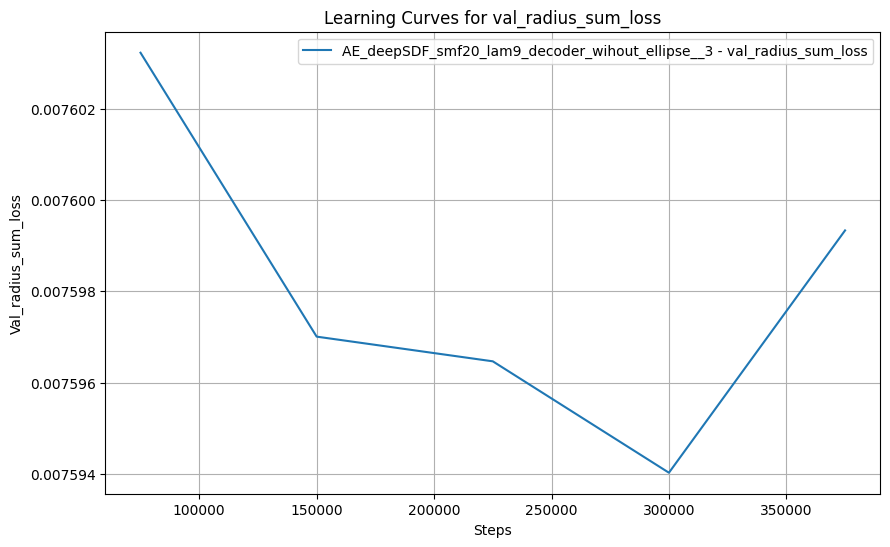

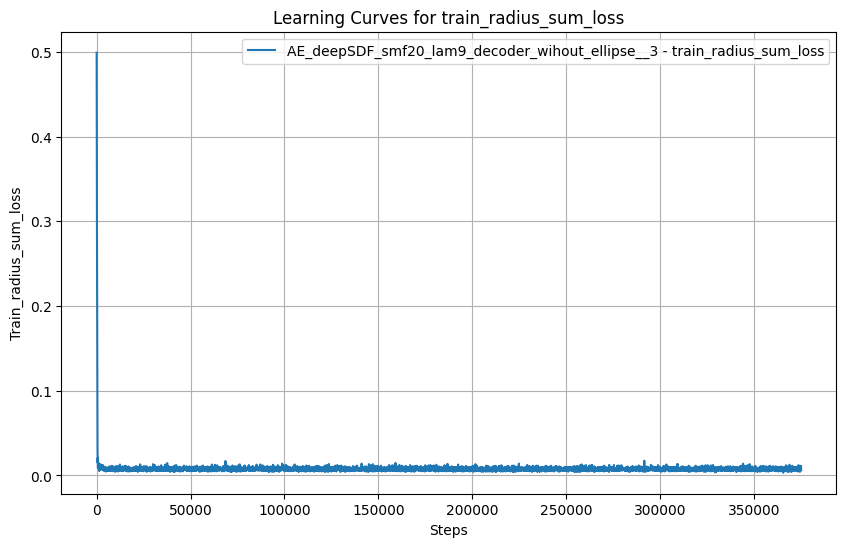

In [5]:
from vizualization_utils import plot_learning_curves

# Example usage
log_directory = './logs/VAEi'
# # subdirs = [run_name]
# subdirs = ['AE_deepSDF_smf20_lam9_only_radius_sum_one_layer',
#             'AE_deepSDF_smf20_lam9_only_radius_sum_two_layers', 
#             'AE_deepSDF_smf20_lam9_only_radius_sum_three_layers',
#             'AE_deepSDF_smf20_lam9_only_radius_sum_three_layers_2'
#             ]

# subdirs = ['AE_deepSDF_smf20_lam9_only_radius_sum_three_layers_3']
subdirs = [run_name]

plot_learning_curves(log_directory, subdirs, metric='val_radius_sum_loss')
plot_learning_curves(log_directory, subdirs, metric='train_radius_sum_loss')

In [7]:
from models.sdf_models import Decoder_loss

# Create a new instance of the decoder_radius_sum model
decoder_radius_sum = Decoder_loss(latent_dim=9, hidden_dim=128)

# Load the saved weights into the new model instance
decoder_radius_sum_weights_path = f'model_weights/decoder_radius_sum_1.pt'
decoder_radius_sum.load_state_dict(torch.load(decoder_radius_sum_weights_path))
print(f"Decoder radius sum weights loaded from {decoder_radius_sum_weights_path}")


Decoder radius sum weights loaded from model_weights/decoder_radius_sum_1.pt


/tmp/ipykernel_13075/457795931.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  decoder_radius_sum.load_state_dict(torch.load(decoder_radius_sum_weights_path))


In [14]:
trainer.validate(vae_trainer, dataloaders=[test_loader, surface_test_loader])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 1: 100%|██████████| 10/10 [00:00<00:00, 18.54it/s]     


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃       DataLoader 1        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val2_mae          │                           │    0.00878933072090149    │
│      val2_recon_loss      │                           │     8.071898460388184     │
│       val2_reg_loss       │                           │    0.5922129154205322     │
│         val2_rmse         │                           │   0.022983789443969727    │
│       val2_sdf_loss       │                           │   0.006183607503771782    │
│      val2_smoothness      │                           │   0.042656995356082916    │
│      val2_total_loss      │                           │   0.006775821093469858    │
│      val_recon_loss       │     1.097779393196106     │                           │
│       val_reg_loss        │    0.05935222655534744    │                           │
│       val_sdf_loss        │   0.0007539546932093799   │                           │
│      val_total_loss       │   0.0008133062510751188   │                           │
└───────────────────────────┴───────────────────────────┴───────────────────────────┘

[{'val_total_loss/dataloader_idx_0': 0.0008133062510751188,
  'val_recon_loss/dataloader_idx_0': 1.097779393196106,
  'val_sdf_loss/dataloader_idx_0': 0.0007539546932093799,
  'val_reg_loss/dataloader_idx_0': 0.05935222655534744},
 {'val2_total_loss/dataloader_idx_1': 0.006775821093469858,
  'val2_recon_loss/dataloader_idx_1': 8.071898460388184,
  'val2_sdf_loss/dataloader_idx_1': 0.006183607503771782,
  'val2_reg_loss/dataloader_idx_1': 0.5922129154205322,
  'val2_mae/dataloader_idx_1': 0.00878933072090149,
  'val2_rmse/dataloader_idx_1': 0.022983789443969727,
  'val2_smoothness/dataloader_idx_1': 0.042656995356082916}]

# Visualization

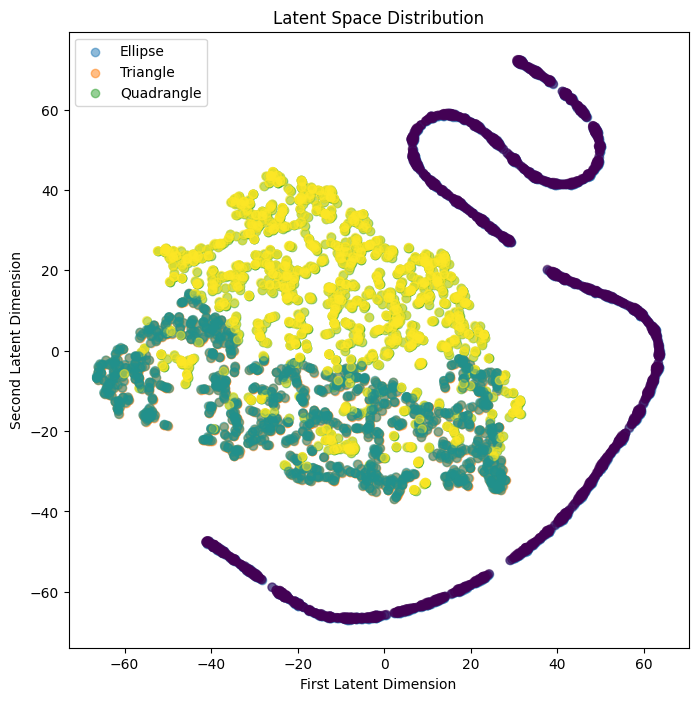

In [6]:
class_names = ['Ellipse', 'Triangle', 'Quadrangle']


def plot_latent_space(model, dataloader, num_samples=4000, filename = None):
    """Visualize the latent space"""
    model.eval()
    latent_vectors = []
    X = []
    sdf = []
    sdf_target = []
    class_labels = []
    with torch.no_grad():
        for batch in dataloader:
            _, sdf_out, mu = model(batch[0])
            latent_vectors.append(mu)
            X.append(batch[0])
            sdf.append(sdf_out)
            sdf_target.append(batch[1])
            class_labels.append(batch[0][:, 2])
            if len(latent_vectors) * batch[0].shape[0] >= num_samples:
                break
                
    latent_vectors = torch.cat(latent_vectors, dim=0)[:num_samples]
    latent_vectors = latent_vectors.cpu().numpy()

    latent_mins = np.min(latent_vectors, axis=0)
    latent_maxs = np.max(latent_vectors, axis=0)

    # Use t-SNE for dimensionality reduction
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_vectors)

    
    # Concatenate and convert class labels
    class_labels = torch.cat(class_labels, dim=0)[:num_samples].cpu().numpy()
    class_labels = [class_names[int(label*2)] for label in class_labels]
    
    # Plot the reduced dimensions with colors based on class labels
    plt.figure(figsize=(8,8))
    # Convert class labels to numeric values for coloring
    unique_labels = list(set(class_labels))
    label_to_num = {label: i for i, label in enumerate(unique_labels)}
    numeric_labels = [label_to_num[label] for label in class_labels]

    # print(numeric_labels)
    # print(unique_labels)
    for i, label in enumerate(class_names):
        class_bids = [x == label for x in class_labels]
        # Get points for this class
        class_points = latent_2d[class_bids]
        class_latent_vectors = latent_vectors[class_bids]
        # Calculate Gaussian parameters for this class
        class_mean = np.mean(class_latent_vectors, axis=0)
        class_cov = np.cov(class_latent_vectors.T)
        # Calculate and print center
        center = np.mean(class_latent_vectors, axis=0)
        # Save center, class_cov, and inverse of class_cov
        class_cov_inv = np.linalg.inv(class_cov)
        np.savez(
            f"model_weights/{run_name}_{label}_stats.npz",
            center=center,
            class_cov=class_cov,
            class_cov_inv=class_cov_inv,
            latent_mins=latent_mins,
            latent_maxs=latent_maxs
        )
        # Plot points
        plt.scatter(class_points[:, 0], class_points[:, 1], label=label, alpha=0.5)

    # Find common mean and covariance for triangles and quadrangles
    triangle_indices = [i for i, label in enumerate(class_labels) if label == 'Triangle']
    quadrangle_indices = [i for i, label in enumerate(class_labels) if label == 'Quadrangle']
    
    triangle_vectors = latent_vectors[triangle_indices]
    quadrangle_vectors = latent_vectors[quadrangle_indices]
    
    combined_vectors = np.vstack((triangle_vectors, quadrangle_vectors))
    
    common_mean = np.mean(combined_vectors, axis=0)
    common_cov = np.cov(combined_vectors.T)

    common_cov_inv = np.linalg.inv(common_cov)
    np.savez(
        f"model_weights/{run_name}_common_stats.npz",
        center=common_mean,
        class_cov=common_cov,
        class_cov_inv=common_cov_inv,
        latent_mins=latent_mins,
        latent_maxs=latent_maxs
    )

    # print(class_labels == 'Ellipse')
    plt.scatter(latent_2d[:,0], latent_2d[:,1], c=numeric_labels, alpha=0.5)

    # print(*scatter.legend_elements())
    plt.title('Latent Space Distribution')
    plt.xlabel('First Latent Dimension')
    plt.ylabel('Second Latent Dimension')
    # plt.legend(*scatter.legend_elements(), labels=unique_labels, title="Classes")
    plt.legend()
    if filename is not None:
        plt.savefig(filename)

    plt.show()

plot_latent_space(vae_model, test_loader, filename=f'src/figures/latent_space_{run_name}.png')

/tmp/ipykernel_8945/2107140111.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


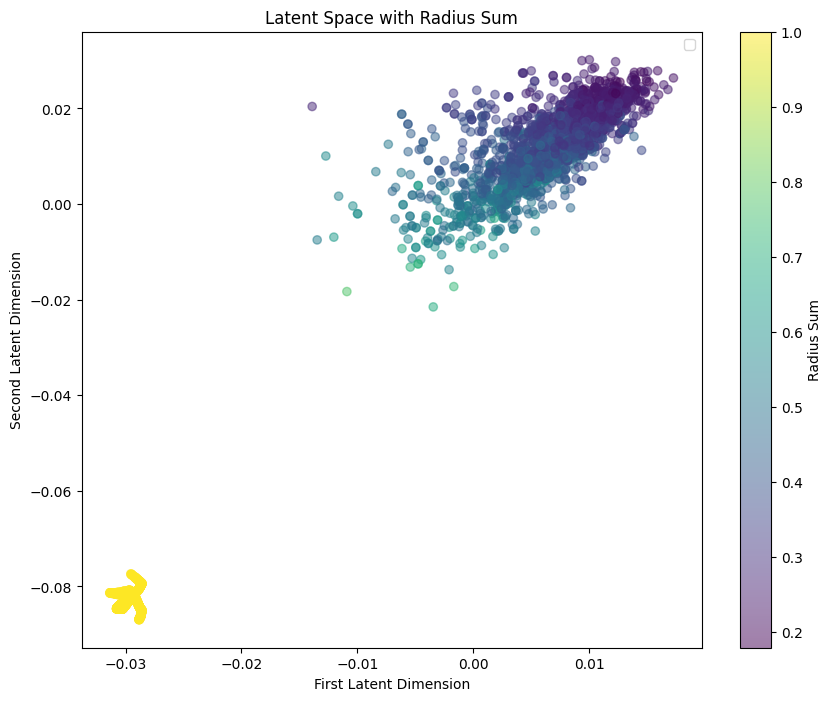

In [7]:
def plot_latent_space_radius_sum(model, dataloader, num_samples=4000, filename = None):
    """Visualize the latent space"""
    model.eval()
    latent_vectors = []
    X = []
    radius_sum_real = []
    sdf = []
    sdf_target = []
    class_labels = []
    with torch.no_grad():
        for batch in dataloader:
            _, sdf_out, mu = model(batch[0])
            latent_vectors.append(mu)
            X.append(batch[0])
            radius_sum_real.append(batch[2])
            sdf.append(sdf_out)
            sdf_target.append(batch[1])
            class_labels.append(batch[0][:, 2])
            if len(latent_vectors) * batch[0].shape[0] >= num_samples:
                break
                
    latent_vectors = torch.cat(latent_vectors, dim=0)[:num_samples]
    latent_vectors = latent_vectors.cpu().numpy()

    latent_vectors_radius_sum = latent_vectors[:, :2]

    radius_sum_real = torch.cat(radius_sum_real, dim=0)[:num_samples]
    radius_sum_real = radius_sum_real.cpu().numpy()

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_vectors_radius_sum[:, 0], latent_vectors_radius_sum[:, 1], c=radius_sum_real, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter, label='Radius Sum')
    plt.title('Latent Space with Radius Sum')
    plt.xlabel('First Latent Dimension')
    plt.ylabel('Second Latent Dimension')
    plt.legend()

    
    if filename is not None:
        plt.savefig(filename)

    plt.show()

plot_latent_space_radius_sum(vae_model, test_loader, filename=f'src/figures/latent_space_radius_sum_{run_name}.png')

<Figure size 1500x500 with 0 Axes>

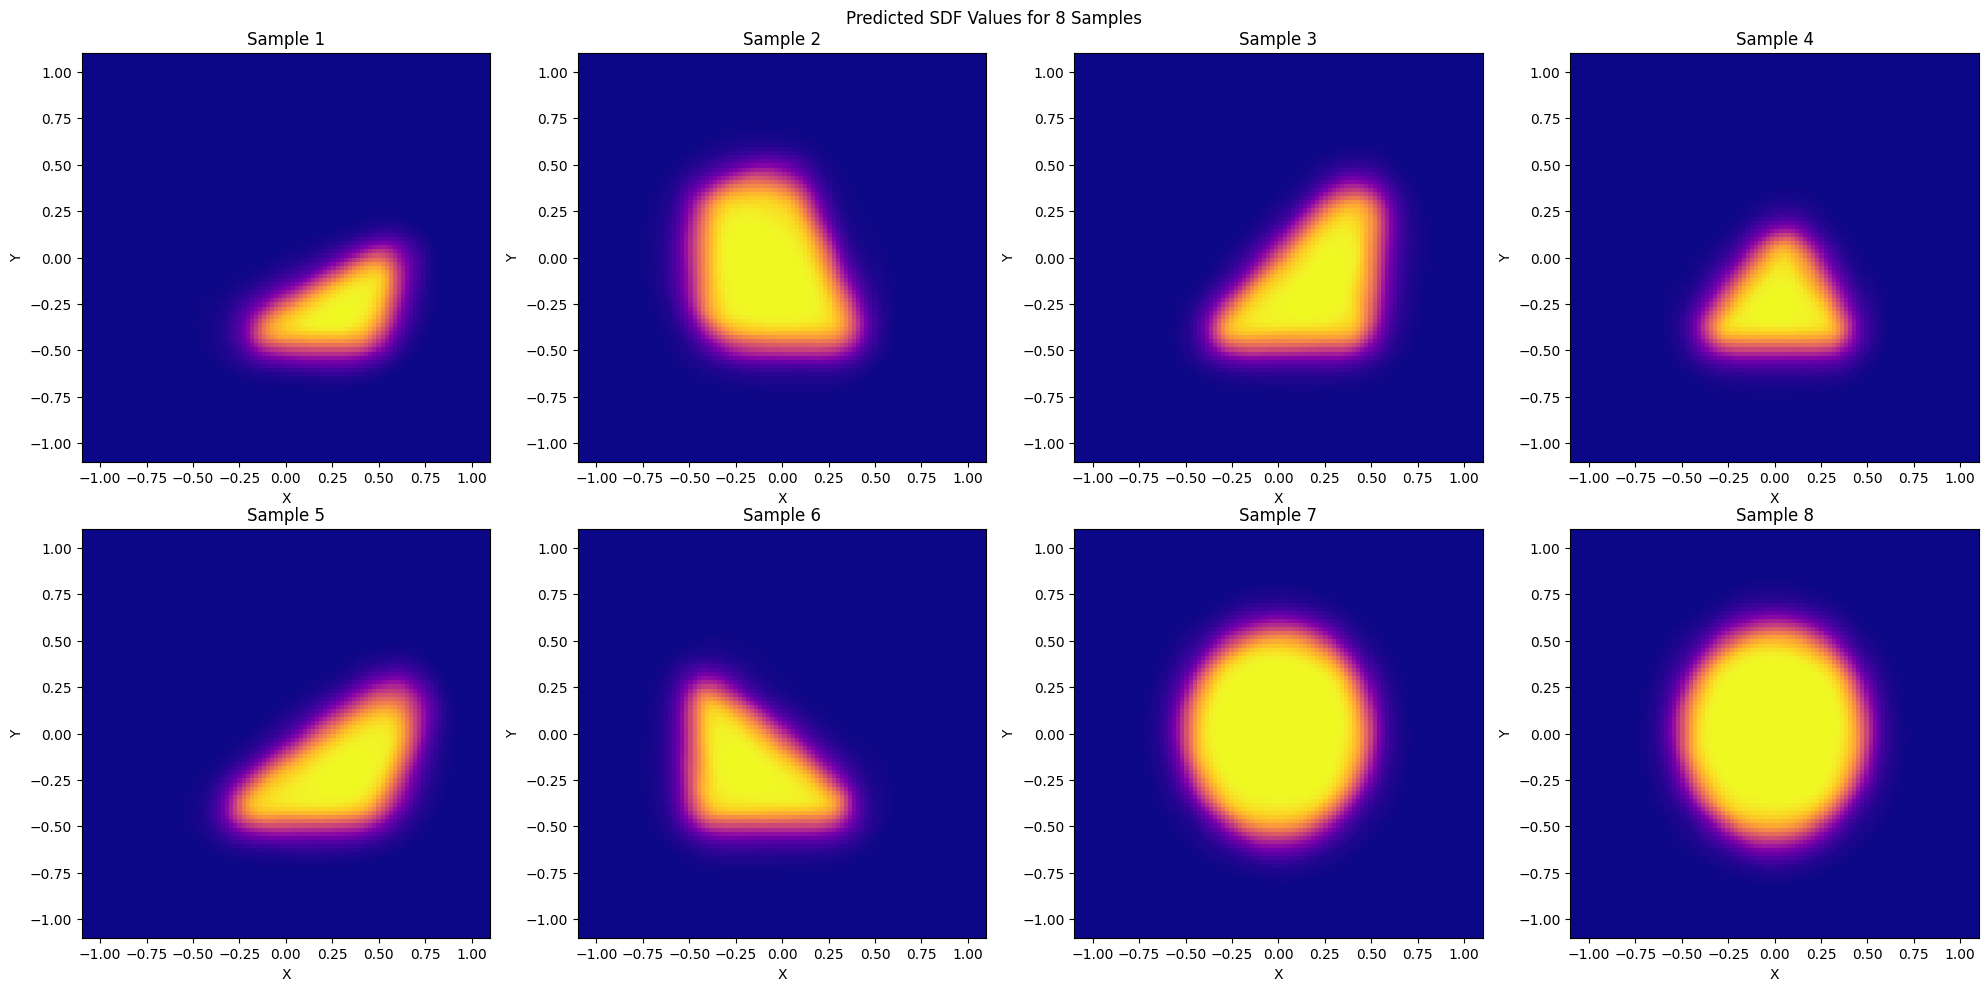

In [8]:
def plot_predicted_sdf(model, test_loader, num_samples=5):
    """Plot predicted SDF values for sample inputs"""
    model.eval()
    plt.figure(figsize=(15, 5))
    
    with torch.no_grad():
        # Get sample batch
        batch = next(iter(test_loader))
        inputs = batch[0][:8]  # Take first 8 samples

        _, _, z = model(inputs)

        x = np.linspace(-1.1, 1.1, 100)
        y = np.linspace(-1.1, 1.1, 100)
        X, Y = np.meshgrid(x, y)
        grid_points = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32)

        fig, axs = plt.subplots(2, 4, figsize=(20, 10))
        fig.suptitle('Predicted SDF Values for 8 Samples')

        for i in range(8):
            row = i // 4
            col = i % 4

            sdf_pred = model.sdf(z[i], grid_points)

            # Reshape predictions
            sdf_grid = sdf_pred.reshape(X.shape)

            # Create scatter plot
            im = axs[row, col].imshow(sdf_grid.numpy(),
                                     extent=[-1.1, 1.1, -1.1, 1.1],
                                     cmap='plasma',
                                     origin='lower')
            axs[row, col].set_aspect('equal')
            axs[row, col].set_title(f'Sample {i+1}')
            axs[row, col].set_xlabel('X')
            axs[row, col].set_ylabel('Y')

        # Add colorbar
        # fig.colorbar(scatter, ax=axs.ravel().tolist(), label='Predicted SDF')

    plt.tight_layout()
    plt.show()

plot_predicted_sdf(vae_model, test_loader)

In [10]:
print(dataset.x_names)

['point_x', 'point_y', 'class', 'semi_axes_ratio', 'v1_x', 'v1_y', 'r_t1', 'r_t2', 'r_t3', 'v3_x', 'v3_y', 'v4_x', 'v4_y', 'r_q1', 'r_q2', 'r_q3', 'r_q4']


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch


def plot_curve(grid_points, sdf_pred, ax):

    curve_mask = torch.logical_and(sdf_pred[:, 0] > 0.3, sdf_pred[:, 0] < 0.7)
    curve_mask_reshaped = curve_mask.reshape(100, 100)[15:85, 15:85]
    # curve_points = grid_points[curve_mask]
    # print(curve_points.shape)
    # ax.scatter(curve_points.numpy()[:, 0], curve_points.numpy()[:, 1], c='r', linewidth=2)
    ax.imshow(curve_mask_reshaped, cmap='gray_r', origin='lower')
    return ax

def plot_sdf_transition(model, z_start, z_end, num_steps=10):
    """
    Plots the transition of SDF maps between two latent vectors.
    
    Parameters:
    - model: The VAE model
    - z_start: The starting latent vector
    - z_end: The ending latent vector
    - num_steps: Number of steps in the transition
    """
    z_start = torch.tensor(z_start, dtype=torch.float32)
    z_end = torch.tensor(z_end, dtype=torch.float32)
    
    # Generate intermediate latent vectors
    z_steps = [z_start + (z_end - z_start) * i / (num_steps - 1) for i in range(num_steps)]
    
    x = np.linspace(-1.1, 1.1, 100)
    y = np.linspace(-1.1, 1.1, 100)
    X, Y = np.meshgrid(x, y)
    grid_points = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32)
    
    fig, axs = plt.subplots(1, num_steps, figsize=(20, 5))
    fig.suptitle('SDF Transition Between Shapes')
    
    with torch.no_grad():
        for i, z in enumerate(z_steps):
            sdf_pred = model.sdf(z, grid_points)
            sdf_grid = sdf_pred.reshape(X.shape)
            
            # im = axs[i].imshow(sdf_grid.numpy(),
            #                 extent=[-1.1, 1.1, -1.1, 1.1],
            #                 cmap='plasma',
            #                 origin='lower')
            plot_curve(grid_points, sdf_pred, axs[i])
            axs[i].set_aspect('equal')
            axs[i].set_frame_on(False)
            axs[i].set_xticks([])
            axs[i].set_yticks([])
            # axs[i].set_title(f'Step {i+1}')
            # axs[i].set_xlabel('X')
            # axs[i].set_ylabel('Y')
        
    plt.tight_layout()
    plt.show()

def plot_sdf_transition_triangle(model, z1, z2, z3, num_steps=10, filename=None):
    """
    Plots the transition of SDF maps between three latent vectors in a triangular format.
    
    Parameters:
    - model: The VAE model
    - z1: The first latent vector
    - z2: The second latent vector
    - z3: The third latent vector
    - num_steps: Number of steps in the transition
    """
    z1 = torch.tensor(z1, dtype=torch.float32)
    z2 = torch.tensor(z2, dtype=torch.float32)
    z3 = torch.tensor(z3, dtype=torch.float32)
    
    # Generate intermediate latent vectors
    z_steps = []
    for i in range(num_steps):
        for j in range(num_steps - i):
            z = z1 * (i / (num_steps - 1)) + z2 * (j / (num_steps - 1)) + z3 * ((num_steps - 1 - i - j) / (num_steps - 1))
            z_steps.append(z)
    
    x = np.linspace(-1.1, 1.1, 100)
    y = np.linspace(-1.1, 1.1, 100)
    X, Y = np.meshgrid(x, y)
    grid_points = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32)
    
    fig, ax = plt.subplots(figsize=(5, 4.5))
    fig.suptitle('SDF Transition Between Shapes in Triangle Format')

    scale = 0.85 / (num_steps - 1)
    
    with torch.no_grad():
        idx = 0
        for i in range(num_steps):
            for j in range(num_steps - i):
                z = z_steps[idx]
                sdf_pred = model.sdf(z, grid_points)
                sdf_grid = sdf_pred.reshape(X.shape)
                
                # Calculate the position for each icon
                x_pos = (i + 0.5 * j) * scale #- 0.55
                y_pos = (np.sqrt(3) / 2 * j) * scale #- 0.55
                
                # Plot each SDF as an icon at the calculated position
                ax_inset = fig.add_axes([x_pos, y_pos, 0.1, 0.1])
                plot_curve(grid_points, sdf_pred, ax_inset)
                ax_inset.set_aspect('equal')
                ax_inset.set_frame_on(False)
                ax_inset.set_xticks([])
                ax_inset.set_yticks([])
                idx += 1
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])
    # plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

def plot_sdf_surface(model, z, countur=False, filename=None):
    z = torch.tensor(z, dtype=torch.float32)
    x = np.linspace(-1.1, 1.1, 100)
    y = np.linspace(-1.1, 1.1, 100)
    X, Y = np.meshgrid(x, y)
    grid_points = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    # fig.suptitle('SDF Surface')
    
    with torch.no_grad():
        sdf_pred = model.sdf(z, grid_points)
        sdf_grid = sdf_pred.reshape(X.shape)
        if countur:
            plot_curve(grid_points, sdf_pred, ax)
        else:
            im = ax.imshow(sdf_grid.numpy(),
                       extent=[-1.1, 1.1, -1.1, 1.1],
                       cmap='plasma',
                       origin='lower')
        
        ax.set_aspect('equal')
        ax.set_frame_on(False)
        ax.set_xticks([])
        ax.set_yticks([])
        # ax.set_title('SDF Surface')
        # ax.set_xlabel('X')
        # ax.set_ylabel('Y')
        
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

def get_latent_subspaces(model, dataloader, num_samples=1000):
    """Visualize the latent space"""

    ellipsoid_label = torch.tensor(0)
    triangle_label = torch.tensor(0.5)
    quadrangle_label = torch.tensor(1)

    model.eval()
    latent_vectors = []
    X = []
    sdf = []
    sdf_target = []
    class_labels = []
    with torch.no_grad():
        for batch in dataloader:
            # print(batch[0].shape)
            # print(batch[0][:, 6])
            updated_input = batch[0].clone()
            for col in [6, 7, 8, 13, 14, 15, 16]:
                mask = batch[0][:, col] > 0
                updated_input[mask, col] = 0.08

            _, sdf_out, mu = model(updated_input)
            latent_vectors.append(mu)
            X.append(updated_input)
            sdf.append(sdf_out)
            sdf_target.append(batch[1])
            class_labels.append(batch[0][:, 2])
            if len(latent_vectors) * batch[0].shape[0] >= num_samples:
                break

    class_labels = torch.cat(class_labels)
    latent_vectors = torch.cat(latent_vectors)

    triangle_latent_vectors = latent_vectors[class_labels == triangle_label]
    quadrangle_latent_vectors = latent_vectors[class_labels == quadrangle_label]
    ellipse_latent_vectors = latent_vectors[class_labels == ellipsoid_label]

    return triangle_latent_vectors, quadrangle_latent_vectors, ellipse_latent_vectors

triangle_latent_vectors, quadrangle_latent_vectors, ellipse_latent_vectors = get_latent_subspaces(vae_model, test_loader)

print(triangle_latent_vectors.shape)
print(quadrangle_latent_vectors.shape)
print(ellipse_latent_vectors.shape)


torch.Size([333, 9])
torch.Size([352, 9])
torch.Size([339, 9])


In [19]:
quadrangle_index = 5 #3 4
triangle_index = 21
ellipse_index = 9

# plot_sdf_surface(vae_model, quadrangle_latent_vectors[quadrangle_index])

# for i in range(0, 100):
#     print(i)
#     plot_sdf_surface(vae_model, ellipse_latent_vectors[i])

z_triangle = triangle_latent_vectors[triangle_index]
z_quadrangle = quadrangle_latent_vectors[quadrangle_index]
z_ellipse = ellipse_latent_vectors[ellipse_index]

/tmp/ipykernel_8945/547907022.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z, dtype=torch.float32)


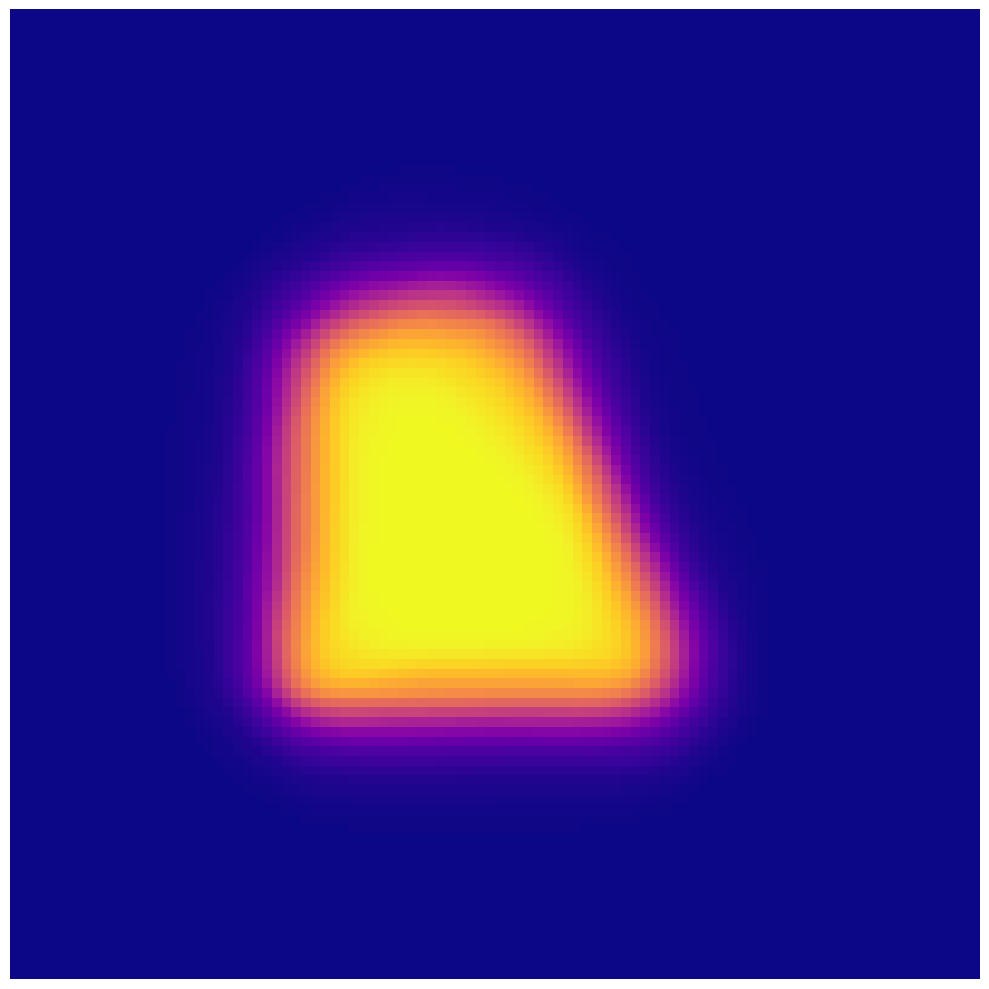

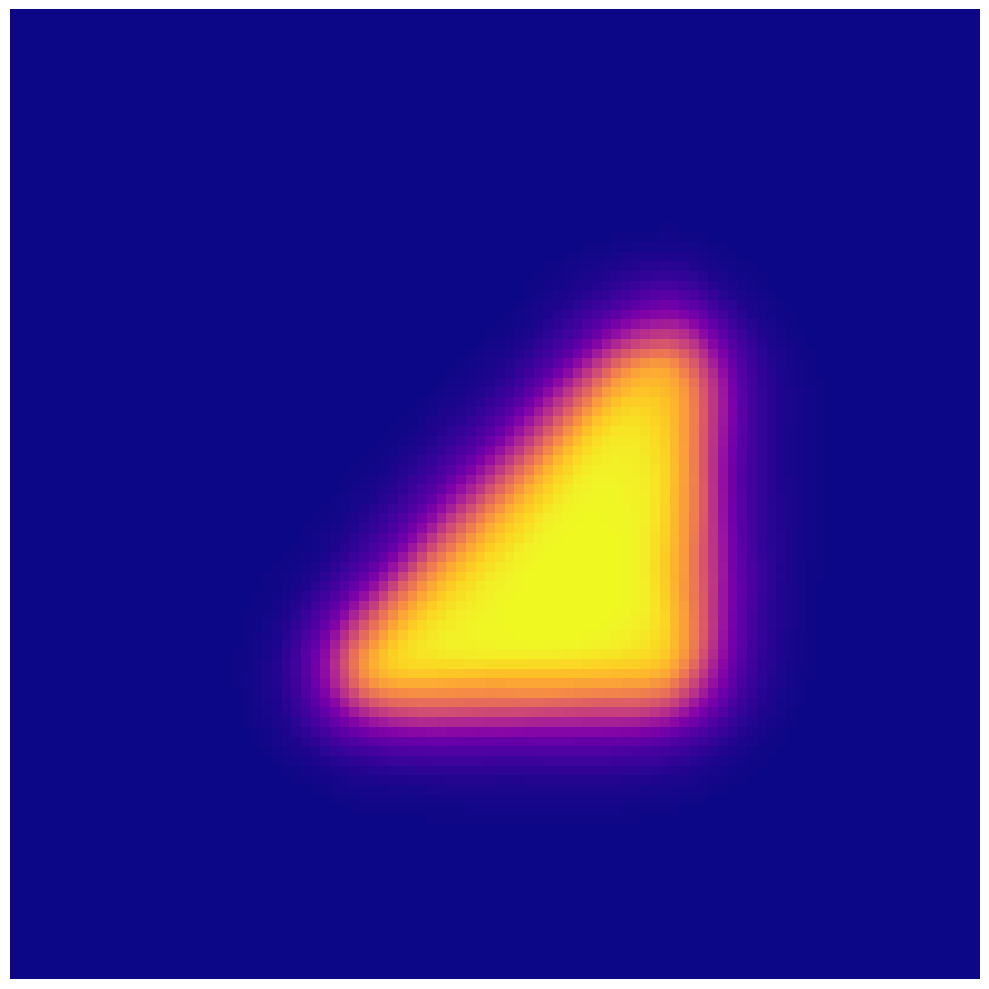

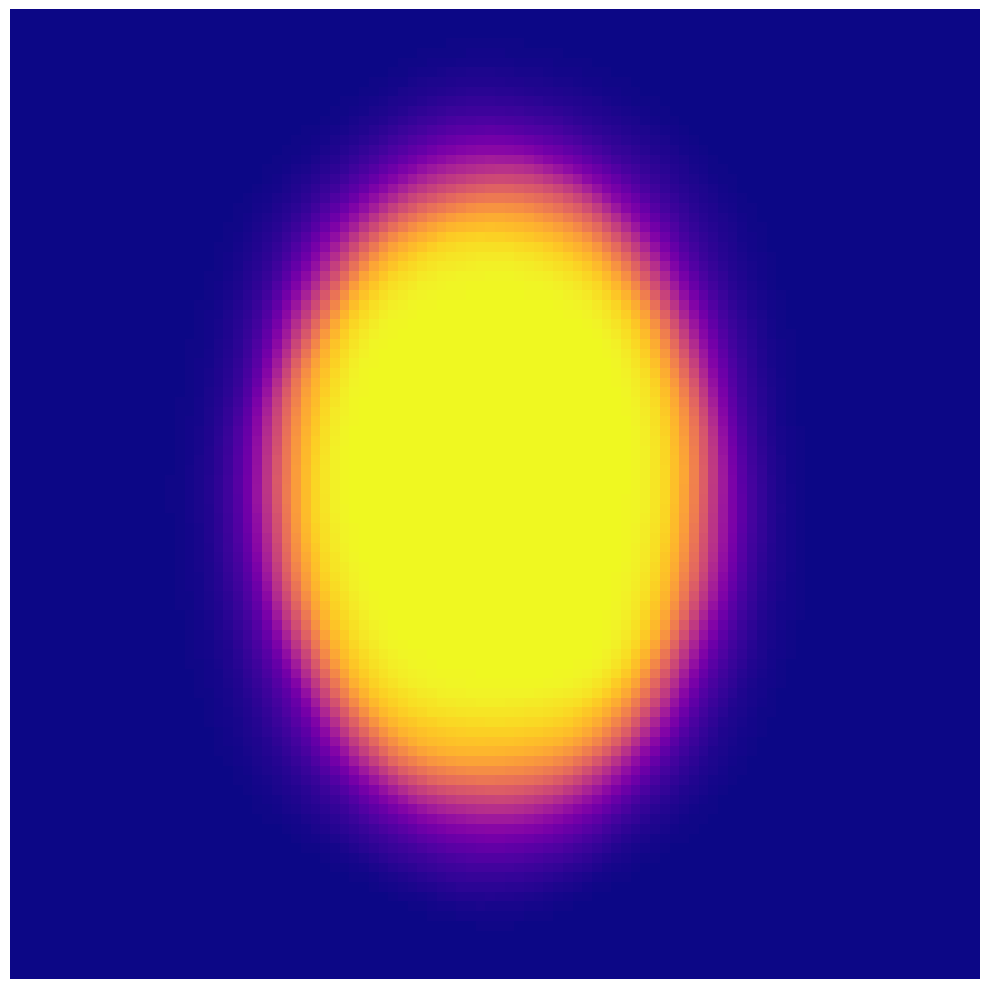

In [20]:
plot_sdf_surface(vae_model, z_quadrangle, countur=False, filename=f'src/figures/sdf_surface_quadrangle_{run_name}.png')
plot_sdf_surface(vae_model, z_triangle, countur=False, filename=f'src/figures/sdf_surface_triangle_{run_name}.png')
plot_sdf_surface(vae_model, z_ellipse, countur=False, filename=f'src/figures/sdf_surface_ellipse_{run_name}.png')


/tmp/ipykernel_8945/547907022.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z1 = torch.tensor(z1, dtype=torch.float32)
/tmp/ipykernel_8945/547907022.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z2 = torch.tensor(z2, dtype=torch.float32)
/tmp/ipykernel_8945/547907022.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z3 = torch.tensor(z3, dtype=torch.float32)


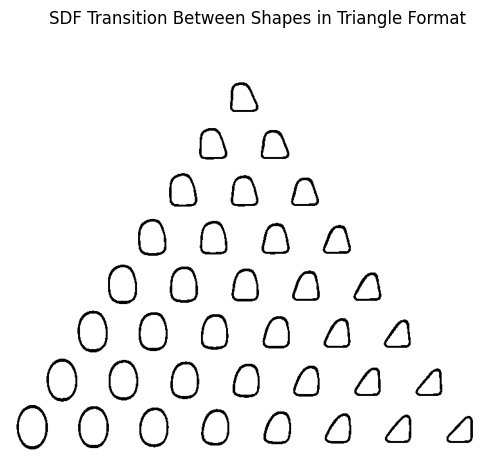

In [21]:
plot_sdf_transition_triangle(vae_model, z_triangle, z_quadrangle, z_ellipse, num_steps=8, filename=f'src/figures/sdf_transition_triangle_{run_name}.png')

# z_start = quadrangle_latent_vectors[quadrangle_index]
# z_end = triangle_latent_vectors[triangle_index]
# plot_sdf_transition(vae_model, z_start, z_end, num_steps=8)

# z_start = quadrangle_latent_vectors[quadrangle_index]
# z_end = ellipse_latent_vectors[ellipse_index]
# plot_sdf_transition(vae_model, z_start, z_end, num_steps=8)

# z_start = ellipse_latent_vectors[ellipse_index]
# z_end = triangle_latent_vectors[triangle_index]
# plot_sdf_transition(vae_model, z_start, z_end, num_steps=8)

# z_center = torch.cat([triangle_latent_vectors[0], quadrangle_latent_vectors[0], ellipse_latent_vectors[0]]).mean(dim=0)
# print(z_center.shape)
# plot_sdf_transition(vae_model, z_center, triangle_latent_vectors[0], num_steps=8)